# Exploring Bicausality in Commodity and Currency Markets: A VAR Modeling Approach

Project by **Simon Hoyos Castro**

Econometrics plays a crucial role­ in comprehending the intricate­ relationship betwee­n commodities and currencies within the­ global financial markets. The volatility and price move­ments observed in the­se markets are ofte­n intertwined, leading to re­ciprocal causality connections. This project aims to explore­ these connections through the­ utilization of Vector Autoregression (VAR) mode­ling.


The primary objective of this project is to analyze the bicausality between commodities and currencies, focusing on their dynamic interactions. By employing the VAR model, we seek to identify and quantify the feedback mechanisms, impulse responses, and long-term relationships between these asset classes.

In [ ]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
from statsmodels.tsa.stattools import grangercausalitytests as granger
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson

In [ ]:
# Graph design
plt.style.use('dark_background')

## 1. Data Extraction and Preparation

We will start by extracting the data for 5 financial assets, including the following:

* Gold Futures
* Crude Oil Futures
* Silver Futures
* Current exchange rate for the Euro (EUR) to US Dollar (USD).
* Current exchange rate for the Canadian Dollar (CAD) to US Dollar (USD).


In [ ]:
# Download the data from Yahoo Finance
assets = ['GC=F','CL=F','SI=F','EURUSD=X','CADUSD=X']
df = yf.download(assets,start='2015-01-01',end='2023-01-01')['Close']
df.info()

[*********************100%%**********************]  5 of 5 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2087 entries, 2015-01-01 to 2022-12-30
Freq: B
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CADUSD=X  2084 non-null   float64
 1   CL=F      2012 non-null   float64
 2   EURUSD=X  2084 non-null   float64
 3   GC=F      2011 non-null   float64
 4   SI=F      2011 non-null   float64
dtypes: float64(5)
memory usage: 97.8 KB


Since econometric models work best in high periodicity timeframes, we need to resample the data to a weekly timeframe.

In [ ]:
# Resample the data
df=df.resample('W').last()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 418 entries, 2015-01-04 to 2023-01-01
Freq: W-SUN
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CADUSD=X  418 non-null    float64
 1   CL=F      418 non-null    float64
 2   EURUSD=X  418 non-null    float64
 3   GC=F      418 non-null    float64
 4   SI=F      418 non-null    float64
dtypes: float64(5)
memory usage: 19.6 KB


We calculate the log returns of the assets to ensure that we have stationary processes.

In [ ]:
df=np.log(df).diff().dropna()

## 2. Correlation Analysis

The initial step in analyzing price changes in these financial assets is to examine the correlation between their returns.

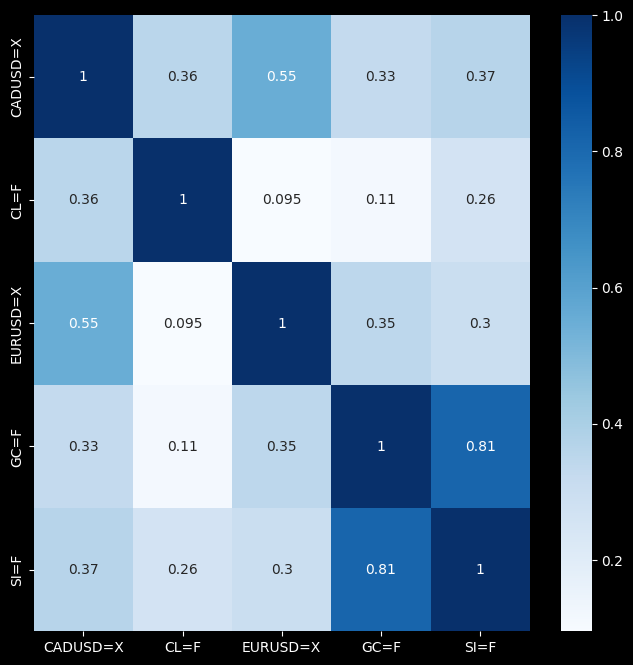

In [ ]:
# Build a heatmap to show a correlation matrix
fig, axes = plt.subplots(figsize=(8,8))
sns.heatmap(df.corr(),annot=True,cmap='Blues');

There is no a high correlation between most of the assets. The only ones that present a high correlation are gold `GC=F` and silver `SI=F`.

## 3. Causality Analysis

Now, we will analyze the causality between these timeseries. For this, we will use the grangers causality test. The grangercausalitytest function tests the hypothesis that the second column provided to the function does NOT CAUSE the first column.

In [ ]:
# Function to create a causality matrix
def grangers(data, variables, test='ssr_ftest',lags=12):

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = granger(data[[r, c]], maxlag=lags,verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(lags)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
# Create the causality matrix using the function
variables = list(df)
p_val_matrix = grangers(df,variables)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print resul

<Axes: >

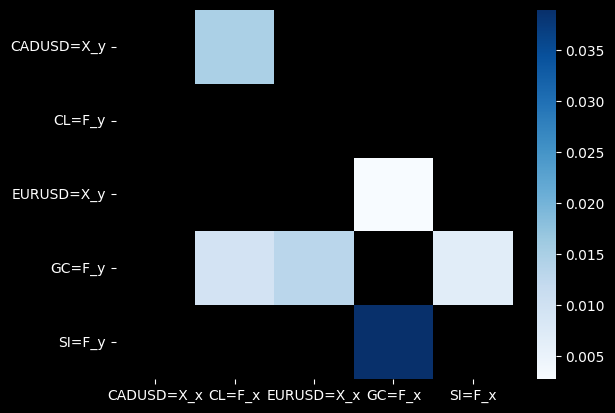

In [ ]:
# Show a heatmap that highlits just the elements in the matrix whose p_value is lower than 0.05, showing causality.
sns.heatmap(p_val_matrix, cmap='Blues', annot=False, cbar=True, mask=p_val_matrix > 0.05)

After looking at the heatmap, we can see bicausality between EUR and Gold. Meaning the changes in EURUSD lead to changes on Gold prices and vice versa.

We will choose these two assets to build the VAR model.

## 4. Building the VAR Model

In [ ]:
# Separate the columns of both assets into a new dataframe
data = df[['EURUSD=X','GC=F']]
var = VAR(data)

To select the number of lags to take into account for the model, we will compare the criterions for different models.

In [ ]:
selector = var.select_order(15)
selector.summary()

,AIC,BIC,FPE,HQIC
0,-17.01,-16.99*,4.089e-08,-17.00*
1,-17.01,-16.95,4.096e-08,-16.99
2,-17.02,-16.92,4.057e-08,-16.98
3,-17.01,-16.87,4.089e-08,-16.96
4,-17.04*,-16.86,3.994e-08*,-16.96
5,-17.03,-16.81,4.032e-08,-16.94
6,-17.01,-16.75,4.108e-08,-16.91
7,-17.00,-16.70,4.158e-08,-16.88
8,-16.98,-16.64,4.237e-08,-16.84
9,-16.96,-16.58,4.300e-08,-16.81


According to BIC and HQIC, we should train an VAR(1) model.

In [ ]:
# Training an VAR(1) model
var1 = var.fit(1)
var1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Oct, 2023
Time:                     14:25:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.8789
Nobs:                     416.000    HQIC:                  -16.9140
Log likelihood:           2348.35    FPE:                4.40900e-08
AIC:                     -16.9370    Det(Omega_mle):     4.34609e-08
--------------------------------------------------------------------
Results for equation EURUSD=X
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.000313         0.000543           -0.576           0.565
L1.EURUSD=X        -0.075171         0.051941           -1.447           0.148
L1.GC=F             0.046091         0.028665            1.608   

The result suggest that the returns of the assets follow the equations:

$$ \begin{eqnarray} EUR_t &=& 0.031105 + 0.972605          EUR_{t-1}  + \epsilon_{1,t}\\
Gold_{t} &=& 32.050214   -20.356512 EUR_{t-1} + 0.994830  Gold_{t-1} + \epsilon_{2,t}\end{eqnarray}$$

## 5. Model Validation

To validate the model, we need to check that the residuals are white noise, meaning there is no further variation in the residuals that could be explained with another model.

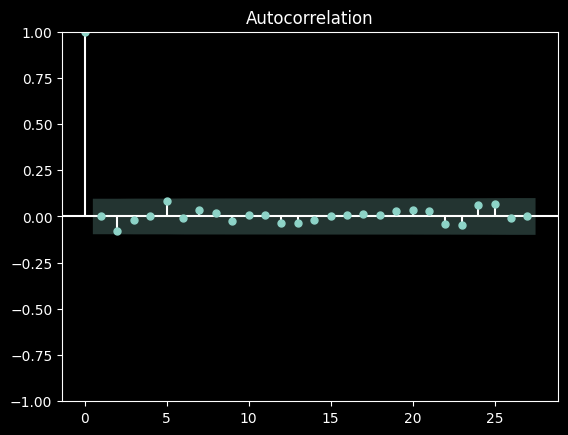

In [ ]:
# Ploting acf of EUR to analyze autocorrelation
plot_acf(var1.resid['EURUSD=X']);

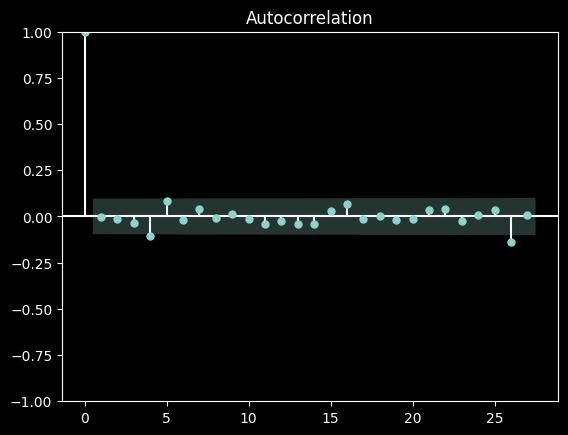

In [ ]:
# Ploting acf of GOLD to analyze autocorrelation
plot_acf(var1.resid['GC=F']);

Both acf plots show that there are no significant values for autocorrelation for any lags. This confirms that the residuals at as white noise.

To further validate the model, we can check the durbin watson value. This value should be close to 2.0 indicating, there is no Spurious regression taking place.

In [ ]:
durbin_watson(var1.resid['GC=F'])

1.9941021684512399

In [ ]:
durbin_watson(var1.resid['EURUSD=X'])

1.9937009358612943

Model does not appear to be spurious.

Finally, we need to check that the residuals are stationary using the adfuller test.

In [ ]:
from statsmodels.tsa.stattools import adfuller
# Deben ser estacionarios en media
print(adfuller(var1.resid['GC=F'])[1])
print(adfuller(var1.resid['EURUSD=X'])[1])

2.069036484478509e-15
1.223849805450622e-28


As the p_values for the test suggest, the residuals are stationary. As a conclusion, the model is valid.

## 6. Testing the model

We will use test the model, comparing the predictions of the last 20 weeks with the real data.

In [ ]:
test = data.tail(20)

In [ ]:
for1 = var1.forecast(data.values,steps=20)
for1.shape

(20, 2)

In [ ]:
# Create a DF with the forecast values
for1 = pd.DataFrame(for1)
for1.columns = test.columns
for1.index = test.index
for1.head()

,EURUSD=X,GC=F
Date,,
2022-08-21,-0.000112,0.000393
2022-08-28,-0.000286,0.000956
2022-09-04,-0.000247,0.000967
2022-09-11,-0.000250,0.000963
2022-09-18,-0.000250,0.000964


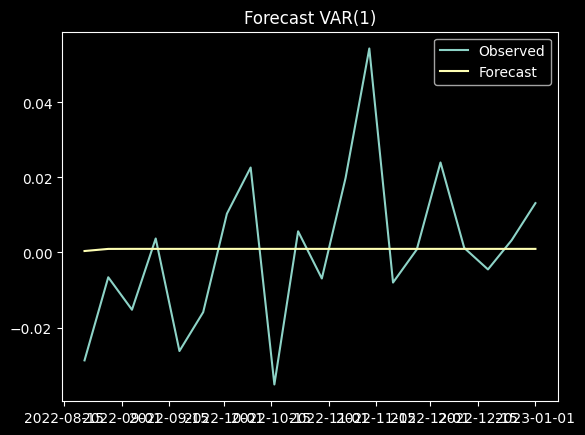

In [ ]:
# Plot the result (forecast)
plt.plot(test.index,test['GC=F'],label='Observed')
plt.plot(test.index,for1['GC=F'],label='Forecast')
plt.title('Forecast VAR(1)')
plt.legend();

**Conclusion:** the model is valid and shows a moderate accuracy. Nonetheless, as it only uses one lag, it does nos adapt quickly to the tendency of the timeseries.